In [ ]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import scipy.constants as sc
from pathlib import Path

temperature = 300  # K
kTval = sc.R * temperature / 1000  # kJ/mol
n_repeat_units = 20
n_samples = 50000
# molecular chain
# T-bond-DPP-bond-T-bond-T-bond-E-bond-T-bond
l = [2.533, 1.432, 3.533, 1.432, 2.533, 1.432, 2.533, 1.433, 1.363, 1.433,2.533, 1.432]
# change the logic of bond order and angle order，l_array[1] rotated by angle[1]
Angle = np.deg2rad(np.array([-14.92, -10.83, 30.79, -30.79, 10.83, 14.92, -14.91, -13.29, -53.16, 53.16, 13.29,14.91]))
rotation = np.array([0, 1, 0, 1, 0, 2, 0, 3, 0, 3, 0, 2])
labels = {
    1: {'label': 'T-DPP', 'color': 'b'},
    2: {'label': 'T-T', 'color': 'm'},
    3: {'label': 'T-E', 'color': 'c'}
}

In [12]:
def read_data(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    mirrored = np.column_stack((-data[:, 0] + 360, data[:, 1]))
    combined = np.vstack((data, mirrored))
    combined = np.unique(combined, axis=0)
    return combined[np.argsort(combined[:, 0])]


def setup_interpolation(data_label):
    data = read_data(Path(f"{data_label['label']}.txt"))
    fitf = interp1d(data[:, 0],
                    data[:, 1],
                    kind='cubic',
                    fill_value="extrapolate")
    norm_val, _ = quad(lambda x: np.exp(-fitf(x) / kTval), 0, 360)
    x_values = np.linspace(0, 360, 1000)
    prob_vals = np.exp(-fitf(x_values) / kTval) / norm_val
    cum_dist = cumulative_trapezoid(prob_vals, x_values, initial=0)
    inv_cdf = interp1d(cum_dist / cum_dist[-1],
                       x_values,
                       kind='cubic',
                       fill_value="extrapolate")
    return {
        'data': data,
        'fitf': fitf,
        'prob_vals': prob_vals,
        'inv_cdf': inv_cdf,
        'x_values': x_values,
        'cum_dist': cum_dist
    }

def plot_dihedral_potentials(interp_data):
    """Plot dihedral potentials and their probability distributions."""
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    for key, data in interp_data.items():
        plt.plot(data['data'][:, 0], data['data'][:, 1],
                f"{data['color']}o", label=data['label'])
        plt.plot(data['x_values'], data['fitf'](data['x_values']),
                f"{data['color']}--", label=f"fit {data['label']}")
    format_subplot("Dihedral Angle [Deg.]", "Dihedral Potential (kJ/mol)",
                  "Dihedral Potentials")
    plt.subplot(1, 3, 2)
    for key, data in interp_data.items():
        plt.plot(data['x_values'], data['prob_vals'],
                f"{data['color']}-", label=data['label'])
    format_subplot("Angle [deg.]", "Probability",
                  "Probability Distributions")
    plt.subplot(1, 3, 3)
    for key, data in interp_data.items():
        plt.plot(data['cum_dist']/data['cum_dist'][-1], data['x_values'],
                f"{data['color']}-", label=data['label'])
    format_subplot("Probability", "Dihedral Angle [deg.]",
                  "Cumulative Probability Distributions")

    plt.tight_layout()
    plt.show()


def format_subplot(xlabel, ylabel, title):
    """Format subplot with consistent styling."""
    plt.xlabel(xlabel, fontsize=16, fontfamily="Helvetica")
    plt.ylabel(ylabel, fontsize=16, fontfamily="Helvetica")
    plt.xticks(fontsize=14, fontfamily="Helvetica")
    plt.yticks(fontsize=14, fontfamily="Helvetica")
    plt.legend(fontsize=14, prop={'family': 'Helvetica'})
    plt.grid(True)
    plt.minorticks_on()
    plt.title(title, fontsize=18, fontfamily="Helvetica")

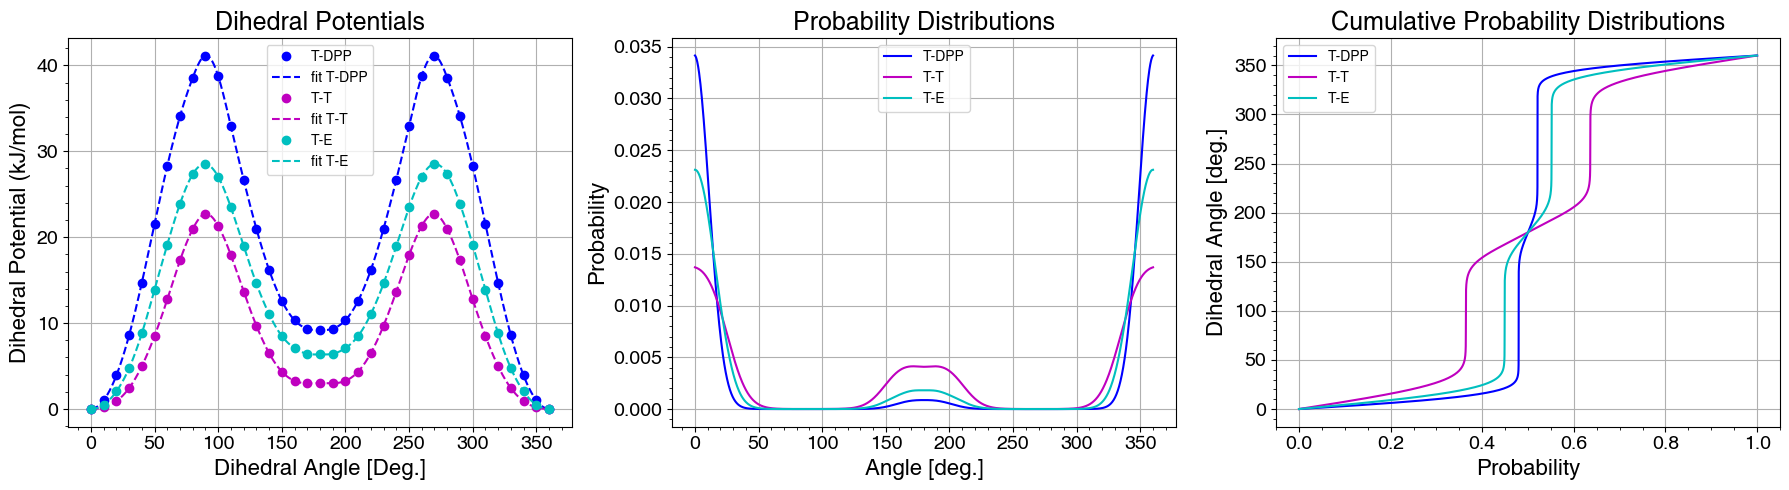

In [13]:
all_data = {}
for key, label_info in labels.items():
    all_data[key] = {**setup_interpolation(label_info), **label_info}
plot_dihedral_potentials(all_data)

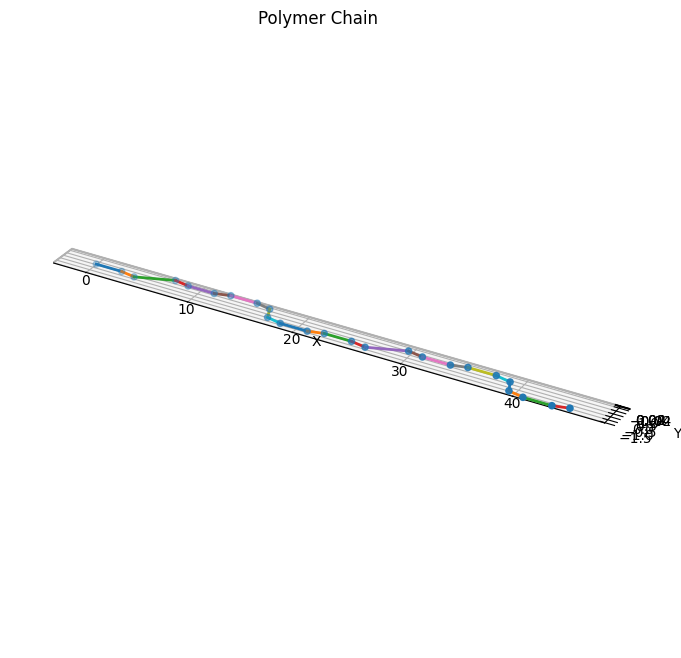

In [14]:
# tested, slightly faster than scipy.spatial.transform.Rotation.from_rotvec
def rotation_matrix(axis, angle):
    """
    Return the rotation matrix associated with 
    counterclockwise rotation about the given 
    axis by angle radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


def chain(n):
    l_array = np.tile(l, n)
    all_l = np.vstack((l_array, np.zeros((2, l_array.shape[0])))).T
    all_angle = np.tile(Angle, n)
    angles = np.cumsum(all_angle[1:])
    vectors = all_l[1:]  # shape (n-1, 3)
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    rotated_x = vectors[:, 0] * cos_angles - vectors[:, 1] * sin_angles
    rotated_y = vectors[:, 0] * sin_angles + vectors[:, 1] * cos_angles
    rotated_z = vectors[:, 2]
    segments = np.column_stack((rotated_x, rotated_y, rotated_z))
    return np.cumsum(np.vstack((np.array([[0, 0, 0], [l[0], 0,
                                                      0]]), segments)),
                     axis=0)


def drawChain(pts):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pts_array = np.array(pts)
    ax.scatter(pts_array[:, 0], pts_array[:, 1], pts_array[:, 2], s=20)
    for i in range(len(pts) - 1):
        ax.plot([pts[i][0], pts[i + 1][0]], [pts[i][1], pts[i + 1][1]],
                [pts[i][2], pts[i + 1][2]],
                linewidth=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    # ax.view_init(elev=90, azim=0)
    plt.title("Polymer Chain")
    plt.show()


drawChain(chain(2))

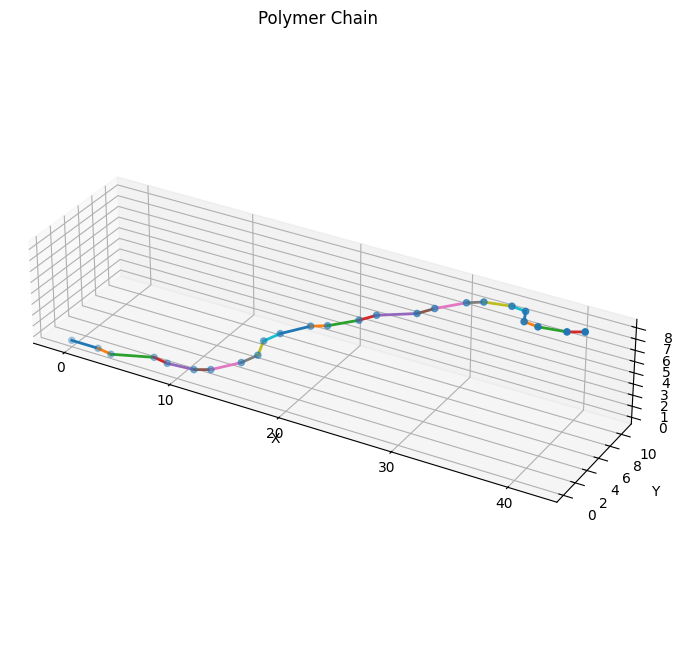

In [15]:
# 比如nb = 2, 则是第一个键的末端，旋转轴为pts[2] - pts[1]，即第一个链接的单键， 3后续的点全部减去pts[2]，用旋转矩阵旋转，再加上pts[2]
length = len(l)

def dihedralRotate(pts, nb, theta_deg):
    theta_rad = np.deg2rad(theta_deg)
    vec = pts[nb] - pts[nb - 1]
    vec_norm = np.linalg.norm(vec)
    axis = vec / vec_norm
    rot = rotation_matrix(axis, theta_rad)
    pts[nb + 1:] = (pts[nb+1:] - pts[nb]) @ rot.T + pts[nb]
    return pts


def randomRotate(pts):
    newpts = pts.copy()
    all_rotaion = rotation[np.arange(0, len(newpts) - 1) % length]
    flat_rotation = np.concatenate([[0], all_rotaion])[:-1]
    for rot_type in labels.keys():
        mask = flat_rotation == rot_type
        if np.any(mask):
            k_values = np.where(mask)[0]
            inv_cdf = all_data[rot_type]['inv_cdf']
            angles = inv_cdf(np.random.rand(len(k_values)))
            for k, angle in zip(k_values, angles):
                dihedralRotate(newpts, k, angle)
    return newpts

drawChain(randomRotate(chain(2)))

In [16]:
def cosVals(pts):
    k_values = np.arange(2, len(pts), length)
    vectors = pts[k_values] - pts[k_values - 1]
    v2 = vectors[0]
    dots = vectors @ v2
    norms = np.linalg.norm(vectors, axis=1) * np.linalg.norm(v2)
    return np.clip(dots / norms, -1, 1)

ch = chain(n_repeat_units)

def calculate_cos_vals(i):
    return cosVals(randomRotate(ch))

import psutil
from joblib import Parallel, delayed
n_jobs = psutil.cpu_count(logical=False)
cosList2 = Parallel(n_jobs=n_jobs, verbose=1)(delayed(calculate_cos_vals)(i) for i in range(n_samples))
corr2 = np.mean(np.array(cosList2), axis=0)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 6640 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 22640 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done 45040 tasks      | elapsed:   25.5s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:   28.3s finished


slope: -0.1111400046752511
Correlation length: 8.997660229743378


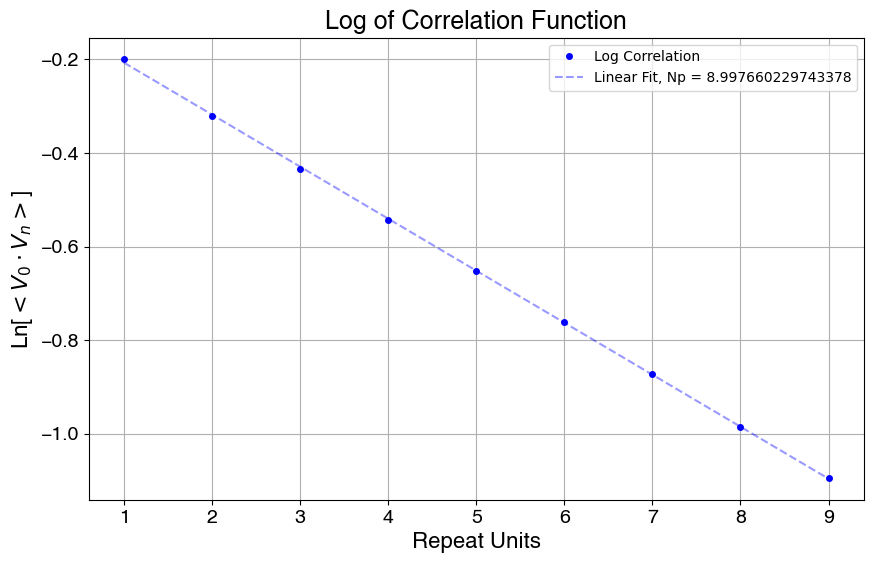

In [17]:
repeat_units = np.arange(len(corr2))
start_idx = 1
end_idx = 10
p = np.polynomial.polynomial.polyfit( repeat_units[start_idx:end_idx], np.log(corr2[start_idx:end_idx]), 1)
persistence_length = -1 / p[1]
print(f"slope: {p[1]}")
print(f"Correlation length: {persistence_length}")

plt.figure(figsize=(10, 6))
plt.plot(repeat_units[start_idx:end_idx],
         np.log(corr2[start_idx:end_idx]),
         'bo',
         markersize=4,
         label='Log Correlation')
plt.plot(repeat_units[start_idx:end_idx],
         np.polynomial.polynomial.polyval(repeat_units[start_idx:end_idx], p),
         'b--', alpha=0.4,
         label=f'Linear Fit, Np = {persistence_length}')
plt.xlabel("Repeat Units", fontsize=16, fontfamily="Helvetica")
plt.ylabel(r'Ln[$<V_0 \cdot V_n>$]',
           fontsize=16,
           fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.grid(True)
plt.legend()
plt.title("Log of Correlation Function", fontsize=18, fontfamily="Helvetica")
plt.show()